# Test Gridworld Pipeline

Simple test of the interpolative planner on a small gridworld.

In [1]:
import numpy as np
import torch
import torch.nn as nn
from problems import GridworldProblem
from policies import RandomPolicy, GreedyPolicy
from planning import WaypointPlanner
from learning import initialize_encoder_random, learning_epoch
from collections import deque
import copy

## Create a Small Gridworld

In [2]:
# Small 3x3 gridworld with no obstacles
K, N, O, r = 20, 2, 2, 5
env = GridworldProblem(K=K, N=N, O=O, r=r, seed=42)

print(f"Environment: {K}x{K} grid, {N} dimensions")
print(f"State space size: {K**N}")
print(f"Action space size: {2*N}")

Environment: 20x20 grid, 2 dimensions
State space size: 400
Action space size: 4


## Initialize Neural Network Encoder

In [3]:
# Simple small network
state_dim = N
latent_dim = 4
hidden_dims = [8, 8]

psi_net = initialize_encoder_random(state_dim, latent_dim, hidden_dims)
A_torch = nn.Parameter(torch.eye(latent_dim, requires_grad=True))
log_lambda = nn.Parameter(torch.tensor(0.0, requires_grad=True))

print(f"Network: {state_dim} -> {hidden_dims} -> {latent_dim}")
print(f"A shape: {A_torch.shape}")

Network: 2 -> [8, 8] -> 4
A shape: torch.Size([4, 4])


## Create Planners

In [4]:
# Create a few planners
policy = RandomPolicy(env, seed=42)

def make_psi(net):
    def psi_fn(state):
        with torch.no_grad():
            state_tensor = torch.from_numpy(state.astype(np.float32)).unsqueeze(0)
            return net(state_tensor).squeeze(0).numpy()
    return psi_fn

planners = []
for i in range(20):
    start_state, goal_state = env.reset()
    planner = WaypointPlanner(
        start=start_state,
        goal=goal_state,
        env=copy.deepcopy(env),
        policy=policy,
        psi=make_psi(psi_net),
        A=A_torch.detach().numpy(),
        waypoint_type='n',  # No waypoints for simplicity
        max_waypoints=10,
        state_buffer=[],
        M=10,
        c=1.0,
        eps=0.1,
        T=1.0
    )
    planners.append(planner)
    print(f"Planner {i}: {start_state} -> {goal_state}")

print(f"\nCreated {len(planners)} planners")

Planner 0: [7 6] -> [10  3]
Planner 1: [7 2] -> [ 1 11]
Planner 2: [5 1] -> [ 0 11]
Planner 3: [11 16] -> [19  2]
Planner 4: [6 8] -> [ 3 13]
Planner 5: [14  2] -> [13 16]
Planner 6: [7 3] -> [1 5]
Planner 7: [9 3] -> [1 9]
Planner 8: [ 3 13] -> [ 7 13]
Planner 9: [12 17] -> [ 8 14]
Planner 10: [12  0] -> [6 8]
Planner 11: [ 0 11] -> [ 7 10]
Planner 12: [18 16] -> [7 2]
Planner 13: [2 0] -> [4 9]
Planner 14: [6 8] -> [ 7 11]
Planner 15: [1 0] -> [15  4]
Planner 16: [ 2 11] -> [7 2]
Planner 17: [0 2] -> [ 4 14]
Planner 18: [13  2] -> [0 4]
Planner 19: [ 8 14] -> [12 18]

Created 20 planners


In [5]:
def collect_data(replay_buffer, planners):

    # Collect data for a few steps
    for step in range(100):
        for planner in planners:
            action, waypoint, done = planner.step()
            
            # Sample (current_state, future_state) pair from trajectory
            if len(planner.trajectory) >= 2:
                current_idx = np.random.randint(0, len(planner.trajectory) - 1)
                current_state = planner.trajectory[current_idx]
                future_state = planner.sample_future_state(current_idx, p=0.9)
                
                if future_state is not None:
                    replay_buffer.append((current_state.copy(), future_state.copy()))
            
            if done:
                start_state, goal_state = env.reset()
                planner.reset(start_state, goal_state)

    print(f"Replay buffer size: {len(replay_buffer)}")
    print(f"Sample pair: {replay_buffer[0][0]} -> {replay_buffer[0][1]}")

    return replay_buffer

In [6]:
def update_planners(replay_buffer, planners, psi_net, A_torch, log_lambda):
    if len(replay_buffer) >= 8:
        # Sample a small batch
        batch_size = min(8, len(replay_buffer))
        indices = np.random.choice(len(replay_buffer), size=batch_size, replace=False)
        batch = [replay_buffer[i] for i in indices]
        
        current_states = [s for s, _ in batch]
        future_states = [s_plus for _, s_plus in batch]
        
        print(f"Batch size: {len(current_states)}")
        
        # Run learning
        psi_net, A_torch, log_lambda, policy, metrics = learning_epoch(
            psi_net, A_torch, log_lambda,
            current_states, future_states, env,
            learning_rate=0.001,
            iters_per_epoch=20,
            policy_temperature=1.0,
            c_target=1.0
        )
    
        print("\nMetrics:")
        for key, value in metrics.items():
            print(f"  {key}: {value:.4f}")

        A_np = A_torch.detach().numpy()
        state_buffer = []
        for current_state, future_state in replay_buffer:
            state_buffer.append(current_state.copy())
            state_buffer.append(future_state.copy())
            
        for planner in planners:
            planner.policy = policy
            planner.psi = make_psi(psi_net)
            planner.A = A_np
            planner.state_buffer = state_buffer  # Update shared buffer from replay buffer

        return planners, psi_net, A_torch, log_lambda
    else:
        print("Not enough data in replay buffer")

In [7]:
replay_buffer = deque(maxlen=1000)
for i in range(100):
    replay_buffer = collect_data(replay_buffer, planners)
    planners, psi_net, A_torch, log_lambda = update_planners(replay_buffer, planners, psi_net, A_torch, log_lambda)
    

Replay buffer size: 1000
Sample pair: [7 2] -> [6 2]
Batch size: 8

Metrics:
  loss: 1.9835
  l_unif: 1.9798
  l_align: 0.0037
  accuracy: 0.8750
  l2: 0.0613
  lambda: 0.9812
  total_loss: 2.0258
Replay buffer size: 1000
Sample pair: [10  0] -> [9 0]
Batch size: 8

Metrics:
  loss: 2.0336
  l_unif: 2.0280
  l_align: 0.0056
  accuracy: 0.7500
  l2: 0.0277
  lambda: 0.9617
  total_loss: 2.0222
Replay buffer size: 1000
Sample pair: [11  0] -> [11  1]
Batch size: 8

Metrics:
  loss: 1.9339
  l_unif: 1.9237
  l_align: 0.0102
  accuracy: 0.7500
  l2: 0.0755
  lambda: 0.9427
  total_loss: 1.9504
Replay buffer size: 1000
Sample pair: [9 3] -> [10  3]
Batch size: 8

Metrics:
  loss: 1.9166
  l_unif: 1.8931
  l_align: 0.0235
  accuracy: 0.8750
  l2: 0.0895
  lambda: 0.9240
  total_loss: 1.9273
Replay buffer size: 1000
Sample pair: [10  5] -> [9 5]
Batch size: 8

Metrics:
  loss: 1.6694
  l_unif: 1.6408
  l_align: 0.0286
  accuracy: 0.7500
  l2: 0.2621
  lambda: 0.9059
  total_loss: 1.8339
Repla

## Collect Some Trajectory Data

In [66]:
replay_buffer = deque(maxlen=10000)

# Collect data for a few steps
for step in range(100):
    for planner in planners:
        action, waypoint, done = planner.step()
        
        # Sample (current_state, future_state) pair from trajectory
        if len(planner.trajectory) >= 2:
            current_idx = np.random.randint(0, len(planner.trajectory) - 1)
            current_state = planner.trajectory[current_idx]
            future_state = planner.sample_future_state(current_idx, p=0.9)
            
            if future_state is not None:
                replay_buffer.append((current_state.copy(), future_state.copy()))
        
        if done:
            start_state, goal_state = env.reset()
            planner.reset(start_state, goal_state)

print(f"Replay buffer size: {len(replay_buffer)}")
print(f"Sample pair: {replay_buffer[0][0]} -> {replay_buffer[0][1]}")

Replay buffer size: 2000
Sample pair: [5 8] -> [4 8]


## Run One Learning Step

In [67]:
if len(replay_buffer) >= 8:
    # Sample a small batch
    batch_size = min(8, len(replay_buffer))
    indices = np.random.choice(len(replay_buffer), size=batch_size, replace=False)
    batch = [replay_buffer[i] for i in indices]
    
    current_states = [s for s, _ in batch]
    future_states = [s_plus for _, s_plus in batch]
    
    print(f"Batch size: {len(current_states)}")
    
    # Run learning
    psi_net, A_torch, log_lambda, policy, metrics = learning_epoch(
        psi_net, A_torch, log_lambda,
        current_states, future_states, env,
        learning_rate=0.001,
        iters_per_epoch=20,
        policy_temperature=1.0,
        c_target=1.0
    )
    
    print("\nMetrics:")
    for key, value in metrics.items():
        print(f"  {key}: {value:.4f}")

    A_np = A_torch.detach().numpy()
    state_buffer = []
    for current_state, future_state in replay_buffer:
        state_buffer.append(current_state.copy())
        state_buffer.append(future_state.copy())
        
    for planner in planners:
        planner.policy = policy
        planner.psi = make_psi(psi_net)
        planner.A = A_np
        planner.state_buffer = state_buffer  # Update shared buffer from replay buffer

else:
    print("Not enough data in replay buffer")

Batch size: 8

Metrics:
  loss: 1.1397
  l_unif: 1.0445
  l_align: 0.0952
  accuracy: 0.8750
  l2: 0.8072
  lambda: 0.5407
  total_loss: 1.4575


## Test the Learned Policy

In [8]:
%load_ext autoreload
%autoreload 2

In [27]:
def s_encoder(state):
    """Encode state: A @ psi(state)"""
    with torch.no_grad():
        state_tensor = torch.from_numpy(state.astype(np.float32)).unsqueeze(0)
        emb = psi_net(state_tensor).squeeze(0).numpy()
        return A_torch.detach().numpy() @ emb

test_policy = GreedyPolicy(copy.deepcopy(env), s_encoder=s_encoder, temperature=0.1)

# Test on a random start/goal
start_state, goal_state = env.reset()
print(f"Testing: {start_state} -> {goal_state}")
print(f"Manhattan distance: {env.get_distance(start_state, goal_state)}")

trajectory = [start_state.copy()]
for step in range(100):
    current_state = env.current_state
    
    with torch.no_grad():
        goal_tensor = torch.from_numpy(goal_state.astype(np.float32)).unsqueeze(0)
        goal_emb = psi_net(goal_tensor).squeeze(0).numpy()
    
    action = test_policy.get_action(current_state, goal_emb)
    if action is None:
        print(f"Step {step}: No valid actions!")
        break
    
    next_state, reward, done, info = env.step(action)
    trajectory.append(next_state.copy())
    
    print(f"Step {step}: {current_state} -> action {action} -> {next_state} (dist={env.get_distance(next_state, goal_state)})")
    
    if done:
        print(f"\nReached goal in {step + 1} steps!")
        break

print(f"\nTrajectory length: {len(trajectory) - 1}")
print(f"Success: {np.array_equal(trajectory[-1], goal_state)}")

Testing: [12  2] -> [7 5]
Manhattan distance: 8
Step 0: [12  2] -> action 2 -> [11  2] (dist=7)
Step 1: [11  2] -> action 2 -> [10  2] (dist=6)
Step 2: [10  2] -> action 3 -> [10  1] (dist=7)
Step 3: [10  1] -> action 1 -> [10  2] (dist=6)
Step 4: [10  2] -> action 2 -> [9 2] (dist=5)
Step 5: [9 2] -> action 1 -> [9 3] (dist=4)
Step 6: [9 3] -> action 2 -> [8 3] (dist=3)
Step 7: [8 3] -> action 1 -> [8 4] (dist=2)
Step 8: [8 4] -> action 2 -> [7 4] (dist=1)
Step 9: [7 4] -> action 1 -> [7 5] (dist=0)

Reached goal in 10 steps!

Trajectory length: 10
Success: True


## Visualize 2D Trajectory (if N=2)

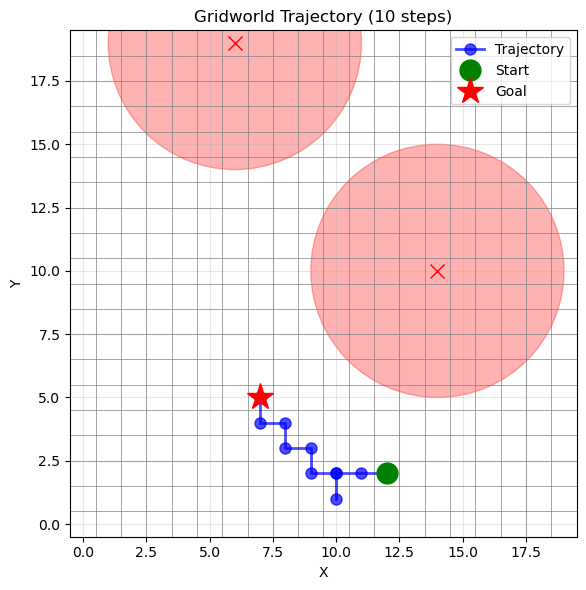

In [28]:
if N == 2:
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Plot grid
    for i in range(K + 1):
        ax.axhline(i - 0.5, color='gray', linewidth=0.5)
        ax.axvline(i - 0.5, color='gray', linewidth=0.5)
    
    # Plot obstacles
    if O > 0:
        for obs in env.obstacles:
            circle = plt.Circle(obs, r, color='red', alpha=0.3)
            ax.add_patch(circle)
            ax.plot(obs[0], obs[1], 'rx', markersize=10)
    
    # Plot trajectory
    traj_array = np.array(trajectory)
    ax.plot(traj_array[:, 0], traj_array[:, 1], 'b-o', linewidth=2, markersize=8, alpha=0.7, label='Trajectory')
    
    # Plot start and goal
    ax.plot(start_state[0], start_state[1], 'go', markersize=15, label='Start')
    ax.plot(goal_state[0], goal_state[1], 'r*', markersize=20, label='Goal')
    
    ax.set_xlim(-0.5, K - 0.5)
    ax.set_ylim(-0.5, K - 0.5)
    ax.set_aspect('equal')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'Gridworld Trajectory ({len(trajectory) - 1} steps)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print(f"Visualization only available for 2D gridworlds (N=2), but N={N}")

In [27]:
def s_encoder(state):
    """Encode state: A @ psi(state)"""
    with torch.no_grad():
        state_tensor = torch.from_numpy(state.astype(np.float32)).unsqueeze(0)
        emb = psi_net(state_tensor).squeeze(0).numpy()
        return A_torch.detach().numpy() @ emb
    
def f_encoder(state):
    with torch.no_grad():
        state_tensor = torch.from_numpy(state.astype(np.float32)).unsqueeze(0)
        emb = psi_net(state_tensor).squeeze(0).numpy()
        return emb


In [12]:
np.exp(-0.5 * np.linalg.norm(s_encoder(start_state) - f_encoder(goal_state))**2)

np.float32(0.80602604)

In [279]:
goal_state

array([12, 17])

In [26]:
gamma = 0.99

In [289]:
np.linalg.norm(s_encoder(start_state) - f_encoder(goal_state))**2

np.float32(22.357485)

In [27]:
1/(2 * np.log(gamma)) * np.linalg.norm(s_encoder(goal_state) - f_encoder(goal_state))**2

np.float64(-14.912021844708931)

In [31]:
gamma = 0.9

In [32]:
def dist_heur(start, goal):
    d_sg = np.linalg.norm(s_encoder(start) - f_encoder(goal))
    d_gg = np.linalg.norm(s_encoder(goal) - f_encoder(goal))
    return 1/(2 * np.log(gamma)) * (d_gg ** 2 - d_sg ** 2)

In [38]:
start_state = np.array([0, 0])
goal_state = np.array([0, 10])

In [39]:
2 * np.sqrt(dist_heur(start_state, goal_state))

np.float64(7.12278027452869)

# Test Full Pipeline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pipeline import train, evaluate

In [12]:
# Design configuration with overrides
from omegaconf import OmegaConf
import yaml

# Load base config
with open('conf/config.yaml', 'r') as f:
    base_config = yaml.safe_load(f)

# Convert to OmegaConf for easy manipulation
config = OmegaConf.create(base_config)

# Apply overrides (modify these as needed)
config.seed = 123
config.env.K = 10
config.env.N = 2
config.env.O = 0
config.model.k = 4
config.training.num_epochs = 3000
config.training.N_T = 50
config.training.learning_rate = 5e-3
config.training.temperature = 1
config.planner.waypoint_type = 'n'  # Options: 'c', 'i', 'n'
config.eval.temperature = 0.01
config.eval.eval_frequency = 100

print("Configuration:")
print(OmegaConf.to_yaml(config))


Configuration:
seed: 123
env:
  K: 10
  'N': 2
  O: 0
  r: 1.5
  gamma: 0.9
model:
  k: 4
  hidden_dims:
  - 64
  - 64
planner:
  waypoint_type: 'n'
  max_waypoints: 10
  M: 50
  eps: 0.1
training:
  N_T: 50
  num_epochs: 3000
  batch_size: 128
  buffer_size: 10000
  learn_frequency: 10
  learning_rate: 0.005
  iters_per_epoch: 1
  c_target: 1.0
  eval_frequency: 100
  temperature: 1
eval:
  num_test_pairs: 50
  num_trials_per_pair: 10
  max_steps: 100
  temperature: 0.01
  eval_frequency: 100
hydra:
  run:
    dir: outputs/${now:%Y-%m-%d}/${now:%H-%M-%S}



In [13]:
psi_net, A_np, log_lambda_np, env, train_time, history = train(config)

Created 50 planners
Epoch 10: Buffer size = 550, Loss = 5.0202, Alignment Loss = 0.02749503031373024, Uniformity Loss = 4.710564613342285, Accuracy = 3.91%, L2 = 0.2821, LR = 0.005000, Temp = 1.000
Epoch 20: Buffer size = 1050, Loss = 4.8521, Alignment Loss = 0.026999691501259804, Uniformity Loss = 4.722450256347656, Accuracy = 3.91%, L2 = 0.1077, LR = 0.005000, Temp = 1.000
Epoch 30: Buffer size = 1550, Loss = 4.9023, Alignment Loss = 0.04708651080727577, Uniformity Loss = 4.661320209503174, Accuracy = 3.91%, L2 = 0.2038, LR = 0.004999, Temp = 1.000
Epoch 40: Buffer size = 2050, Loss = 4.8544, Alignment Loss = 0.04410279914736748, Uniformity Loss = 4.648468971252441, Accuracy = 5.47%, L2 = 0.1768, LR = 0.004998, Temp = 1.000
Epoch 50: Buffer size = 2550, Loss = 4.8902, Alignment Loss = 0.06584697961807251, Uniformity Loss = 4.600727081298828, Accuracy = 2.34%, L2 = 0.2436, LR = 0.004997, Temp = 0.999
Epoch 60: Buffer size = 3050, Loss = 4.8157, Alignment Loss = 0.04510430991649628, Un

In [14]:
def s_encoder(state):
    """Encode state: A @ psi(state)"""
    with torch.no_grad():
        state_tensor = torch.from_numpy(state.astype(np.float32)).unsqueeze(0)
        emb = psi_net(state_tensor).squeeze(0).numpy()
        return A_np @ emb
    
def f_encoder(state):
    with torch.no_grad():
        state_tensor = torch.from_numpy(state.astype(np.float32)).unsqueeze(0)
        emb = psi_net(state_tensor).squeeze(0).numpy()
        return emb


In [15]:
test_policy = GreedyPolicy(copy.deepcopy(env), s_encoder=s_encoder, temperature=config.eval.temperature)


In [16]:

# Test on a random start/goal
start_state, goal_state = env.reset()
print(f"Testing: {start_state} -> {goal_state}")
print(f"Manhattan distance: {env.get_distance(start_state, goal_state)}")

trajectory = [start_state.copy()]
for step in range(100):
    current_state = env.current_state
    
    with torch.no_grad():
        goal_tensor = torch.from_numpy(goal_state.astype(np.float32)).unsqueeze(0)
        goal_emb = psi_net(goal_tensor).squeeze(0).numpy()
    
    action = test_policy.get_action(current_state, goal_emb)
    if action is None:
        print(f"Step {step}: No valid actions!")
        break
    
    next_state, reward, done, info = env.step(action)
    trajectory.append(next_state.copy())
    
    print(f"Step {step}: {current_state} -> action {action} -> {next_state} (dist={env.get_distance(next_state, goal_state)})")
    
    if done:
        print(f"\nReached goal in {step + 1} steps!")
        break

print(f"\nTrajectory length: {len(trajectory) - 1}")
print(f"Success: {np.array_equal(trajectory[-1], goal_state)}")

Testing: [9 2] -> [9 0]
Manhattan distance: 2
Step 0: [9 2] -> action 3 -> [9 1] (dist=1)
Step 1: [9 1] -> action 3 -> [9 0] (dist=0)

Reached goal in 2 steps!

Trajectory length: 2
Success: True


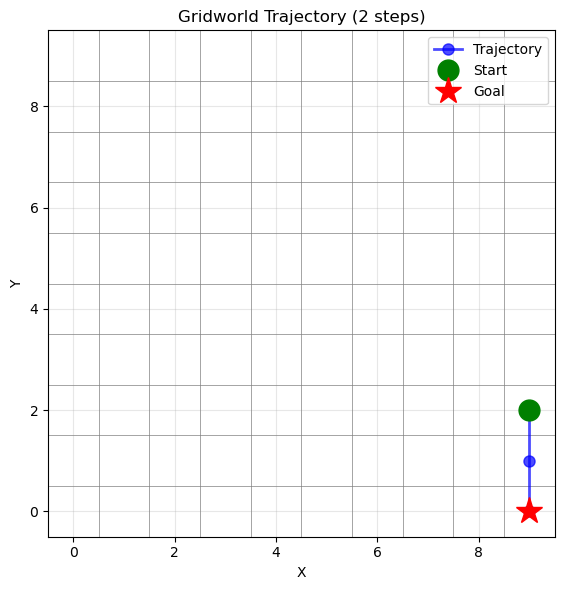

In [17]:
if config.env.N == 2:
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Plot grid
    for i in range(config.env.K + 1):
        ax.axhline(i - 0.5, color='gray', linewidth=0.5)
        ax.axvline(i - 0.5, color='gray', linewidth=0.5)
    
    # Plot obstacles
    if config.env.O > 0:
        for obs in env.obstacles:
            circle = plt.Circle(obs, config.env.r, color='red', alpha=0.3)
            ax.add_patch(circle)
            ax.plot(obs[0], obs[1], 'rx', markersize=10)
    
    # Plot trajectory
    traj_array = np.array(trajectory)
    ax.plot(traj_array[:, 0], traj_array[:, 1], 'b-o', linewidth=2, markersize=8, alpha=0.7, label='Trajectory')
    
    # Plot start and goal
    ax.plot(start_state[0], start_state[1], 'go', markersize=15, label='Start')
    ax.plot(goal_state[0], goal_state[1], 'r*', markersize=20, label='Goal')
    
    ax.set_xlim(-0.5, config.env.K - 0.5)
    ax.set_ylim(-0.5, config.env.K - 0.5)
    ax.set_aspect('equal')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'Gridworld Trajectory ({len(trajectory) - 1} steps)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print(f"Visualization only available for 2D gridworlds (N=2), but N={N}")

In [18]:
def dist_heur(start, goal):
    d_sg = np.linalg.norm(s_encoder(start) - f_encoder(goal))
    d_gg = np.linalg.norm(s_encoder(goal) - f_encoder(goal))
    return 1/(2 * np.log(config.env.gamma)) * (d_gg ** 2 - d_sg ** 2)

In [21]:
def new_dist_heur(start, goal):
    d_sg = np.linalg.norm(s_encoder(start) - f_encoder(goal))
    d_gg = np.linalg.norm(s_encoder(goal) - f_encoder(goal))
    return 1/(2 * np.log(config.env.gamma)) * (d_gg - d_sg)

In [39]:
start = np.array([0, 0])
goal = np.array([9, 9])
print("Dist:", dist_heur(start, goal))
print("Modded Dist:", np.sqrt(dist_heur(start, goal)))
print("New Dist:", new_dist_heur(start, goal))

Dist: 159.47677343187343
Modded Dist: 12.628411358198363
New Dist: 27.3612379720284


In [71]:
config.eval.temperature = 0.01
results = evaluate(psi_net, A_np, env, config)


Evaluation Results:
Success Rate: 22.40%
Mean Path Length: 82.33
Mean Manhattan Length: 28.02
Efficiency: 190.82%
MSE Path Length: 4210.85
Evaluation Time: 11.77s


In [ ]:
n = 0
tot = 0
for i in range(len(results['all_lens'])):
    l = results['all_lens'][i]
    for j in range(len(l)):
        if l[j] != 100:
            n += 1
            tot += l[j] / results['all_manhattan_lens'][i]
            print(l[j], results['all_manhattan_lens'][i])
print(tot / n)



15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
23 15
29 15
15 15
15 15
21 15
15 15
21 15
19 15
15 15
27 21
29 21
29 21
27 21
27 21
27 21
27 21
27 21
27 21
27 21
9 7
7 7
7 7
7 7
7 7
7 7
7 7
7 7
7 7
7 7
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
26 26
26 26
98 42
50 30
50 30
46 30
50 30
48 30
40 30
40 30
46 30
42 30
38 30
19 19
19 19
19 19
19 19
21 19
19 19
19 19
19 19
21 19
18 18
18 18
20 18
18 18
22 18
18 18
18 18
18 18
18 18
18 18
26 26
26 26
26 26
26 26
26 26
26 26
26 26
26 26
26 26
26 26
27 21
27 21
27 21
27 21
27 21
27 21
27 21
27 21
27 21
27 21
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
6 6
1.1392946652345153


In [66]:
results['all_lens']

[[100, 100, 100, 100, 91, 100, 100, 100, 100, 100],
 [100, 49, 19, 13, 100, 100, 100, 11, 100, 100],
 [85, 53, 65, 69, 65, 99, 57, 53, 59, 51],
 [100, 100, 100, 100, 100, 100, 100, 100, 100, 100],
 [100, 100, 4, 100, 4, 100, 52, 4, 4, 4],
 [19, 19, 29, 27, 25, 33, 23, 19, 41, 23],
 [100, 69, 65, 81, 59, 69, 100, 67, 99, 59],
 [100, 100, 100, 100, 100, 100, 100, 100, 100, 100],
 [100, 100, 100, 100, 100, 100, 100, 100, 100, 100],
 [100, 100, 100, 100, 100, 100, 32, 100, 100, 100],
 [97, 100, 100, 100, 100, 100, 100, 100, 100, 100],
 [100, 100, 100, 100, 100, 100, 100, 100, 100, 100],
 [41, 100, 100, 37, 100, 45, 41, 100, 100, 100],
 [100, 100, 100, 82, 100, 100, 100, 100, 100, 100],
 [100, 100, 100, 100, 100, 100, 100, 100, 100, 100],
 [99, 100, 100, 100, 100, 100, 100, 83, 100, 100],
 [100, 100, 100, 100, 100, 95, 100, 100, 100, 100],
 [100, 100, 100, 100, 100, 100, 100, 100, 100, 100],
 [41, 43, 43, 51, 100, 49, 53, 47, 27, 63],
 [100, 100, 100, 100, 100, 100, 100, 100, 100, 100],
 [9

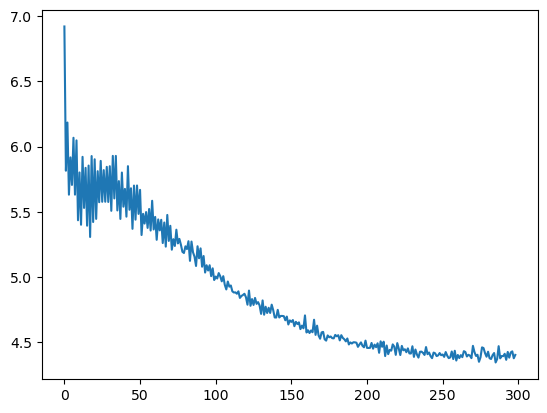

In [73]:
plt.plot(history['loss'])

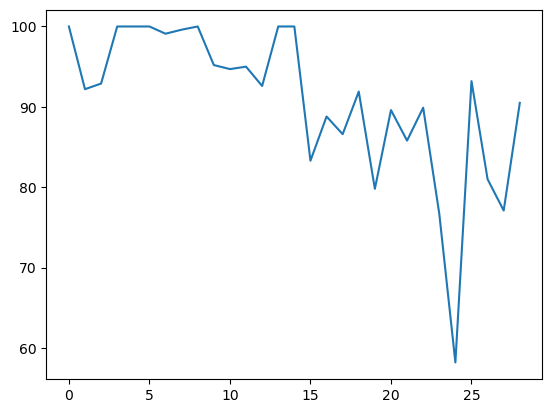

In [79]:
plt.plot(history['mean_path_length'])